1. Importing Libraries

In [46]:
import os, re, shutil
from pathlib import Path

import sys, math, gc, glob
import numpy as np, pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, utils

2. Handling NULL Values

In [47]:
METADATA_CSV = r"D:\nutrition5k_dataset\metadata\dish_metadata.csv"   
REALSENSE_DIR = r"D:\nutrition5k_dataset\imagery\realsense_overhead"

df = pd.read_csv(METADATA_CSV, dtype=object) 
orig_rows = len(df)
print(f"Loaded metadata: {orig_rows} rows, {len(df.columns)} columns")

Loaded metadata: 3265 rows, 244 columns


In [48]:
if "dish_id" not in df.columns:
    df = df.rename(columns={df.columns[0]: "dish_id"})
    print(f"No 'dish_id' column found; renamed first column to 'dish_id' ({df.columns[0]})")

# Case 1: Null Target columns
dish_targets = ["total_calories", "total_mass", "total_fat", "total_carb", "total_protein"]
existing_targets = [c for c in dish_targets if c in df.columns]
print("Detected dish-level target columns:", existing_targets)

def mark_nulls(series):
    return series.replace(["", " ", "NULL", "null", "NaN", "nan"], pd.NA).isna()

mask_drop = pd.Series(False, index=df.index)
for col in existing_targets:
    null_mask = mark_nulls(df[col])
    mask_drop = mask_drop | null_mask
drop_count = mask_drop.sum()

# Deleting images for above dish_ids
dropped_dish_ids = df.loc[mask_drop, "dish_id"].astype(str).tolist()

# Case 2: Null Dish-level numeric columns
if drop_count > 0:
    df = df.loc[~mask_drop].reset_index(drop=True)
print(f"Dropped {int(drop_count)} rows because one or more dish-level target columns were NULL.")

# Case 3 : NULL Ingredient-level numeric columns
ingr_num_pattern = re.compile(r"^ingr_\d+_(grams|calories|fat|carb|protein)$", flags=re.IGNORECASE)
ingr_num_cols = [c for c in df.columns if ingr_num_pattern.match(c)]
for c in ingr_num_cols:
    df[c] = df[c].replace(["", " ", "NULL", "null", "NaN", "nan"], 0)
    df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0)
print(f"Found and filled {len(ingr_num_cols)} ingredient numeric columns with NULL -> 0.")

# Removing Ingredient name columns
ingr_name_pattern = re.compile(r"^ingr_\d+_name$", flags=re.IGNORECASE)
ingr_name_cols = [c for c in df.columns if ingr_name_pattern.match(c)]
df.drop(columns=ingr_name_cols, inplace=True)
print(f"Removed {len(ingr_name_cols)} ingredient name columns (e.g. ingr_1_name).")

# Case 4: Replacing NULL with 0 as fallback
remaining_cols = [c for c in df.columns if c not in ("dish_id",) + tuple(ingr_num_cols)]
for c in remaining_cols:
    df[c] = df[c].replace(["", " ", "NULL", "null", "NaN", "nan"], 0)
    # try convert to numeric then fallback to string '0' if conversion fails
    try:
        df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0)
    except Exception:
        df[c] = df[c].astype(object).fillna(0)

print(f"Applied fallback NULL->0 to remaining {len(remaining_cols)} columns (excluding dish_id).")

Detected dish-level target columns: ['total_calories', 'total_mass', 'total_fat', 'total_carb', 'total_protein']
Dropped 0 rows because one or more dish-level target columns were NULL.
Found and filled 170 ingredient numeric columns with NULL -> 0.
Removed 34 ingredient name columns (e.g. ingr_1_name).
Applied fallback NULL->0 to remaining 39 columns (excluding dish_id).


In [49]:
# Deleting corresponding image records
deleted_folders = 0
deleted_files = 0
for dish in dropped_dish_ids:
    dish = str(dish).strip()
    if dish == "" or pd.isna(dish):
        continue
    folder = Path(REALSENSE_DIR) / dish
    if folder.exists():
        try:
            shutil.rmtree(folder)
            deleted_folders += 1
        except Exception as e:
            print(f"Failed to delete folder {folder}: {e}")
    else:
        matches = list(Path(REALSENSE_DIR).glob(f"{dish}*"))
        for m in matches:
            try:
                if m.is_dir():
                    shutil.rmtree(m)
                else:
                    m.unlink()
                deleted_files += 1
            except Exception as e:
                print(f"Failed to delete {m}: {e}")

print(f"Removed {deleted_folders} overhead image folders and {deleted_files} individual files for {len(dropped_dish_ids)} dropped dishes.")

Removed 0 overhead image folders and 0 individual files for 0 dropped dishes.


In [50]:
out_path = Path(METADATA_CSV).with_suffix(".cleaned.csv")
df.to_csv(out_path, index=False)
print(f"Cleaned metadata written to: {out_path}")

final_rows = len(df)
print("Summary:")
print(f"  Original rows: {orig_rows}")
print(f"  Rows dropped (null dish-targets): {int(drop_count)}")
print(f"  Final rows remaining: {final_rows}")
print(f"  Ingredient numeric columns zero-filled: {len(ingr_num_cols)}")
print(f"  Ingredient name columns removed: {len(ingr_name_cols)}")
print(f"  Cleaned CSV saved at: {out_path}")

Cleaned metadata written to: D:\nutrition5k_dataset\metadata\dish_metadata.cleaned.csv
Summary:
  Original rows: 3265
  Rows dropped (null dish-targets): 0
  Final rows remaining: 3265
  Ingredient numeric columns zero-filled: 170
  Ingredient name columns removed: 34
  Cleaned CSV saved at: D:\nutrition5k_dataset\metadata\dish_metadata.cleaned.csv


3. Train and Test split

In [51]:
dish_metadata_path = r"D:\nutrition5k_dataset\metadata\dish_metadata_cleaned.csv"  
train_ids_path = r"D:\nutrition5k_dataset\dish_ids\splits\train.txt"             
test_ids_path  = r"D:\nutrition5k_dataset\dish_ids\splits\test.txt"                
images_root    = r"D:\nutrition5k_dataset\imagery\realsense_overhead"             
output_root    = r"D:\nutrition5k_dataset\split"                                  

train_img_dir = os.path.join(output_root, "train")
test_img_dir  = os.path.join(output_root, "test")

os.makedirs(train_img_dir, exist_ok=True)
os.makedirs(test_img_dir,  exist_ok=True)
print("Output directories ready.\n")

Output directories ready.



In [52]:
# LOAD DISH METADATA
df = pd.read_csv(dish_metadata_path)
print("Loaded dish_metadata_cleaned.csv with rows:", len(df))

# LOAD TRAIN/TEST IDs
with open(train_ids_path, "r") as f:
    train_ids = set(line.strip() for line in f if line.strip())
with open(test_ids_path, "r") as f:
    test_ids = set(line.strip() for line in f if line.strip())
print("Train IDs loaded:", len(train_ids))
print("Test IDs loaded:", len(test_ids))

# FILTER METADATA INTO TRAIN & TEST
df_train = df[df["dish_id"].isin(train_ids)]
df_test  = df[df["dish_id"].isin(test_ids)]
print("Train rows:", len(df_train))
print("Test rows:", len(df_test))

# SAVE SPLIT CSV FILES
os.makedirs(output_root, exist_ok=True)
train_csv_path = os.path.join(output_root, "train.csv")
test_csv_path  = os.path.join(output_root, "test.csv")
df_train.to_csv(train_csv_path, index=False)
df_test.to_csv(test_csv_path, index=False)
print("\ntrain.csv and test.csv successfully created in:", output_root)



Loaded dish_metadata_cleaned.csv with rows: 4768
Train IDs loaded: 2758
Test IDs loaded: 507
Train rows: 2758
Test rows: 507

train.csv and test.csv successfully created in: D:\nutrition5k_dataset\split


In [53]:
# COPY IMAGE FOLDERS
def copy_folders(ids, destination):
    count = 0
    for dish_id in ids:
        src = os.path.join(images_root, dish_id)
        dst = os.path.join(destination, dish_id)

        if os.path.isdir(src):
            if os.path.isdir(dst):
                shutil.rmtree(dst)  
            shutil.copytree(src, dst)
            count += 1
    return count
print("\nCopying TRAIN images...")
train_copied = copy_folders(train_ids, train_img_dir)
print("Copied", train_copied, "train dish folders.")
print("\nCopying TEST images...")
test_copied = copy_folders(test_ids, test_img_dir)
print("Copied", test_copied, "test dish folders.")
print("\nDONE ✓")
print("Images and metadata successfully split for model training.")


Copying TRAIN images...
Copied 2758 train dish folders.

Copying TEST images...
Copied 507 test dish folders.

DONE ✓
Images and metadata successfully split for model training.


4. Architecture

In [54]:
TRAIN_CSV = r"D:\nutrition5k_dataset\split\train.csv"        
TEST_CSV  = r"D:\nutrition5k_dataset\split\test.csv"         
TRAIN_IMAGES_DIR = r"D:\nutrition5k_dataset\split\train"          
TEST_IMAGES_DIR  = r"D:\nutrition5k_dataset\split\test"           
OUT_PRED_CSV = r"D:\nutrition5k_dataset\split\predicted.csv" 

IMG_SIZE = (224,224)  
BATCH_SIZE = 16
EPOCHS = 25           
TARGETS = ["total_calories","total_mass","total_protein","total_fat","total_carb"]

A. IMAGE PROCESSING

In [55]:
def load_overhead_images_for_dish(dish_id, images_root):
    folder = os.path.join(images_root, dish_id)
    if not os.path.isdir(folder):
        return None
    def open_or_none(path):
        if os.path.isfile(path):
            try:
                img = Image.open(path).convert('RGB')
                return img
            except:
                return None
        return None
    rgb = open_or_none(os.path.join(folder,"rgb.png")) or open_or_none(os.path.join(folder,"rgb.jpg"))
    depth_color = open_or_none(os.path.join(folder,"depth_color.png")) or open_or_none(os.path.join(folder,"depth_color.jpg"))
    depth_raw_path = None
    for candidate in ("depth_raw.png","depth_raw.jpg","depth.png","depth.jpg"):
        p = os.path.join(folder, candidate)
        if os.path.isfile(p):
            depth_raw_path = p
            break
    depth_raw = None
    if depth_raw_path:
        try:
            depth_img = Image.open(depth_raw_path)
            depth_raw = depth_img.convert('L')
        except:
            depth_raw = None
    if rgb is None:
        return None
    if depth_color is None:
        depth_color = rgb.copy()  
    if depth_raw is None:
        depth_raw = Image.new('L', rgb.size, color=0)
    rgb = rgb.resize(IMG_SIZE)
    depth_color = depth_color.resize(IMG_SIZE)
    depth_raw = depth_raw.resize(IMG_SIZE)
    return rgb, depth_color, depth_raw

def stack_images_to_array(rgb, depth_color, depth_raw):
    a_rgb = np.asarray(rgb).astype(np.float32) / 255.0
    a_depth_color = np.asarray(depth_color).astype(np.float32) / 255.0
    a_depth_raw = np.expand_dims(np.asarray(depth_raw).astype(np.float32) / 255.0, axis=-1)
    stacked = np.concatenate([a_rgb, a_depth_color, a_depth_raw], axis=-1)  # shape (H,W,7)
    return stacked

B. SAMPLE IMAGE

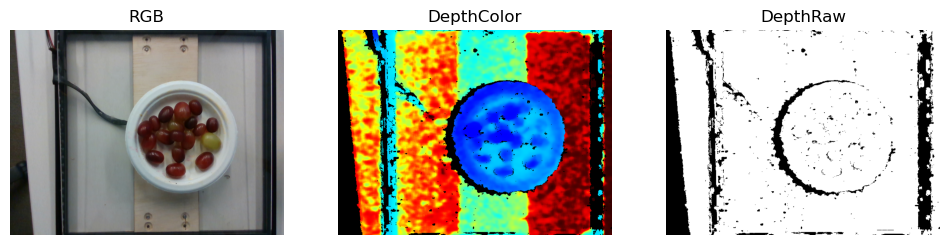

In [56]:
SAMPLE_DISH_DIR_ROOT = r"D:/nutrition5k_dataset/imagery/realsense_overhead/dish_1558115448"  # << EDIT THIS PATH

def load_if_exists(path):
    return Image.open(path) if os.path.exists(path) else None

rgb_paths = glob.glob(os.path.join(SAMPLE_DISH_DIR_ROOT, "rgb*"))
depth_color_paths = glob.glob(os.path.join(SAMPLE_DISH_DIR_ROOT, "depth_color*"))
depth_raw_paths = glob.glob(os.path.join(SAMPLE_DISH_DIR_ROOT, "depth_raw*"))
mask_paths = glob.glob(os.path.join(SAMPLE_DISH_DIR_ROOT, "masks*")) + glob.glob(os.path.join(SAMPLE_DISH_DIR_ROOT,"frames_sampled5","*mask*.png"))

rgb = load_if_exists(rgb_paths[0]) if rgb_paths else None
depth_color = load_if_exists(depth_color_paths[0]) if depth_color_paths else None
depth_raw = load_if_exists(depth_raw_paths[0]) if depth_raw_paths else None
mask = load_if_exists(mask_paths[0]) if mask_paths else None

items = [('RGB', rgb), ('DepthColor', depth_color), ('DepthRaw', depth_raw), ('Mask', mask)]
present = [(n,i) for n,i in items if i is not None]
fig, axes = plt.subplots(1, len(present), figsize=(4*len(present),4))
if len(present)==1:
    axes = [axes]
for ax, (name, img) in zip(axes, present):
    if img.mode not in ('RGB','L'):
        img = img.convert('RGB')
    ax.imshow(img); ax.set_title(name); ax.axis('off')
plt.show()

C. TEXT PROCESSING

In [57]:
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)
print("Train rows:", len(train_df), "Test rows:", len(test_df))

def prepare_tabular(df):
    cols = [c for c in df.columns if c not in (["dish_id"] + TARGETS)]
    # Keep only numeric columns to keep dimensionality small
    numeric_cols = [c for c in cols if pd.api.types.is_numeric_dtype(df[c])]
    X_tab = df[numeric_cols].astype(np.float32).fillna(0).values
    return X_tab, numeric_cols

X_train_tab, tab_cols = prepare_tabular(train_df)
X_test_tab, _ = prepare_tabular(test_df)
print("Tabular numeric feature count:", len(tab_cols))

Train rows: 2758 Test rows: 507
Tabular numeric feature count: 204


D. SCALING

In [58]:
scaler = StandardScaler()
if len(X_train_tab)>0:
    X_train_tab = scaler.fit_transform(X_train_tab)
    X_test_tab = scaler.transform(X_test_tab)
else:
    X_train_tab = np.zeros((len(train_df), 1), dtype=np.float32)
    X_test_tab = np.zeros((len(test_df), 1), dtype=np.float32)

E. LOADING IMAGES

In [59]:
def load_dataset_images(df, images_root):
    imgs = []
    valid_idx = []
    for idx, row in df.iterrows():
        dish = str(row["dish_id"])
        loaded = load_overhead_images_for_dish(dish, images_root)
        if loaded is None:
            # skip if no image
            continue
        rgb, dcolor, draw = loaded
        arr = stack_images_to_array(rgb, dcolor, draw)
        imgs.append(arr)
        valid_idx.append(idx)
    if len(imgs)==0:
        return np.zeros((0,IMG_SIZE[0],IMG_SIZE[1],7),dtype=np.float32), []
    imgs = np.stack(imgs, axis=0)
    return imgs, valid_idx

print("Loading train images...")
X_train_img, train_valid_idx = load_dataset_images(train_df, TRAIN_IMAGES_DIR)
print("Loaded train images:", X_train_img.shape)
print("Loading test images...")
X_test_img, test_valid_idx = load_dataset_images(test_df, TEST_IMAGES_DIR)
print("Loaded test images:", X_test_img.shape)

Loading train images...
Loaded train images: (2755, 224, 224, 7)
Loading test images...
Loaded test images: (507, 224, 224, 7)


In [60]:
y_train = train_df.loc[train_valid_idx, TARGETS].values.astype(np.float32)
X_train_tab_aligned = X_train_tab[train_valid_idx] if X_train_tab.shape[0]==len(train_df) else X_train_tab
X_train_tab_aligned = np.asarray([X_train_tab[i] for i in train_valid_idx]) if X_train_tab.shape[0]==len(train_df) else X_train_tab

y_test = test_df.loc[test_valid_idx, TARGETS].values.astype(np.float32)
X_test_tab_aligned = np.asarray([X_test_tab[i] for i in test_valid_idx]) if X_test_tab.shape[0]==len(test_df) else X_test_tab

print("Aligned train shape:", X_train_img.shape, X_train_tab_aligned.shape, y_train.shape)
print("Aligned test shape:", X_test_img.shape, X_test_tab_aligned.shape, y_test.shape)

if X_train_img.shape[0]==0 or X_test_img.shape[0]==0:
    raise RuntimeError("No images loaded for train or test. Check image paths and dish_id folders.")

Aligned train shape: (2755, 224, 224, 7) (2755, 204) (2755, 5)
Aligned test shape: (507, 224, 224, 7) (507, 204) (507, 5)


F. DEEP LEARNING MODELS

In [61]:
# CNN for 7-channel input
def build_image_encoder(input_shape=(224,224,7)):
    inp = layers.Input(shape=input_shape)
    x = layers.Conv2D(32,3,activation='relu',padding='same')(inp)
    x = layers.MaxPool2D(2)(x)
    x = layers.Conv2D(64,3,activation='relu',padding='same')(x)
    x = layers.MaxPool2D(2)(x)
    x = layers.Conv2D(128,3,activation='relu',padding='same')(x)
    x = layers.MaxPool2D(2)(x)
    x = layers.Conv2D(256,3,activation='relu',padding='same')(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    model = models.Model(inp, x, name="img_encoder")
    return model

# Tabular MLP
def build_tabular_mlp(input_dim):
    inp = layers.Input(shape=(input_dim,))
    x = layers.Dense(128,activation='relu')(inp)
    x = layers.Dense(64,activation='relu')(x)
    model = models.Model(inp, x, name="tabular_mlp")
    return model

img_encoder = build_image_encoder(input_shape=(IMG_SIZE[0],IMG_SIZE[1],7))
tab_mlp = build_tabular_mlp(X_train_tab_aligned.shape[1])

G. FUSION NEURAL NETWORK

In [62]:
img_inp = layers.Input(shape=(IMG_SIZE[0],IMG_SIZE[1],7))
tab_inp = layers.Input(shape=(X_train_tab_aligned.shape[1],))
img_feat = img_encoder(img_inp)
tab_feat = tab_mlp(tab_inp)
combined = layers.concatenate([img_feat, tab_feat])
x = layers.Dense(256, activation='relu')(combined)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(len(TARGETS), activation='linear')(x)
model = models.Model([img_inp, tab_inp], outputs)
model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss='mse', metrics=['mae'])
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 7)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_11      │ (None, 204)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ img_encoder         │ (None, 256)       │    455,360 │ input_layer_10[0… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tabular_mlp         │ (None, 64)        │     34,496 │ input_layer_11[0… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 320)       │          0 │ img_encoder[0][0… │
│ (Concatenate)       │                   │            │ tabular_mlp[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 256)       │     82,176 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 128)       │     32,896 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 5)         │        645 │ dense_16[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 605,573 (2.31 MB)

 Trainable params: 605,573 (2.31 MB)

 Non-trainable params: 0 (0.00 B)

5. Training and testing

In [63]:
history = model.fit([X_train_img, X_train_tab_aligned], y_train,
                    validation_data=([X_test_img, X_test_tab_aligned], y_test),
                    epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

y_pred = model.predict([X_test_img, X_test_tab_aligned])
pred_df = pd.DataFrame(y_pred, columns=[c+"_pred" for c in TARGETS])
pred_df.insert(0, "dish_id", test_df.loc[test_valid_idx,"dish_id"].values)
pred_df.to_csv(OUT_PRED_CSV, index=False)
print("Saved predictions to:", OUT_PRED_CSV)

Epoch 1/25
173/173 ━━━━━━━━━━━━━━━━━━━━ 29s 137ms/step - loss: 21718.2598 - mae: 78.7472 - val_loss: 13247.2441 - val_mae: 63.9877
Epoch 2/25
173/173 ━━━━━━━━━━━━━━━━━━━━ 21s 118ms/step - loss: 14048.3848 - mae: 63.6266 - val_loss: 11106.1133 - val_mae: 60.5631
Epoch 3/25
173/173 ━━━━━━━━━━━━━━━━━━━━ 20s 115ms/step - loss: 9524.7676 - mae: 51.1979 - val_loss: 7631.2168 - val_mae: 43.9787
Epoch 4/25
173/173 ━━━━━━━━━━━━━━━━━━━━ 20s 114ms/step - loss: 5169.9175 - mae: 36.5171 - val_loss: 7090.8774 - val_mae: 34.6067
Epoch 5/25
173/173 ━━━━━━━━━━━━━━━━━━━━ 20s 114ms/step - loss: 3836.0186 - mae: 29.8274 - val_loss: 6252.3740 - val_mae: 30.7534
Epoch 6/25
173/173 ━━━━━━━━━━━━━━━━━━━━ 20s 115ms/step - loss: 3235.8291 - mae: 27.5832 - val_loss: 5821.3521 - val_mae: 28.9258
Epoch 7/25
173/173 ━━━━━━━━━━━━━━━━━━━━ 20s 114ms/step - loss: 2946.7534 - mae: 26.4955 - val_loss: 5868.5366 - val_mae: 27.9908
Epoch 8/25
173/173 ━━━━━━━━━━━━━━━━━━━━ 20s 116ms/step - loss: 2709.7747 - mae: 25.7789 - val

6. Evaluation Metrics

In [64]:
gt_df = test_df.loc[test_valid_idx, ["dish_id"] + TARGETS].reset_index(drop=True)
eval_df = pd.concat([gt_df, pred_df.set_index("dish_id").loc[gt_df["dish_id"]].reset_index(drop=True)], axis=1)

metrics = {}
for t in TARGETS:
    y_true = eval_df[t].values
    y_p = eval_df[t+"_pred"].values
    mae = mean_absolute_error(y_true, y_p)
    rmse = math.sqrt(mean_squared_error(y_true, y_p))
    r2 = r2_score(y_true, y_p)
    metrics[t] = {"MAE": mae, "RMSE": rmse, "R2": r2}
    print(f"{t}: MAE={mae:.3f}, RMSE={rmse:.3f}, R2={r2:.3f}")

total_calories: MAE=44.573, RMSE=151.389, R2=0.490
total_mass: MAE=58.188, RMSE=114.607, R2=0.428
total_protein: MAE=7.306, RMSE=13.774, R2=0.475
total_fat: MAE=6.136, RMSE=10.144, R2=0.485
total_carb: MAE=10.608, RMSE=18.047, R2=-0.073


7. Result Visualization

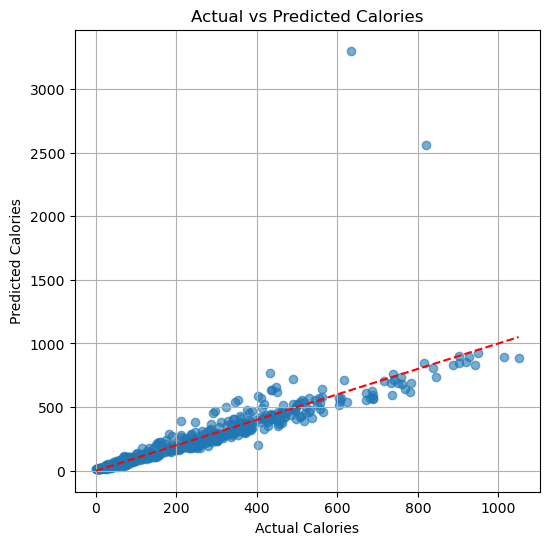

Done. Evaluation metrics printed above. Predictions saved to: D:\nutrition5k_dataset\split\predicted.csv


In [65]:
plt.figure(figsize=(6,6))
plt.scatter(eval_df["total_calories"], eval_df["total_calories_pred"], alpha=0.6)
plt.plot([eval_df["total_calories"].min(), eval_df["total_calories"].max()],
         [eval_df["total_calories"].min(), eval_df["total_calories"].max()], 'r--')
plt.xlabel("Actual Calories")
plt.ylabel("Predicted Calories")
plt.title("Actual vs Predicted Calories")
plt.grid(True)
plt.show()

print("Done. Evaluation metrics printed above. Predictions saved to:", OUT_PRED_CSV)